# Clean and Preprocess Literary Text Files

Import, clean and preprocess the text files of James Joyce's literary works *Dubliners* and *A Portrait of the Artist as a Young Man* for Natural Language Processing.

## Project Notes

Project Notebooks Execution Order:

1. clean-and-preprocess-data.ipynb
2. [natural-language-processing.ipynb](natural-language-processing.ipynb)

# Import Packages and Modules

In [1]:
import os
import re
import time

from cycler import cycler
from IPython.core.interactiveshell import InteractiveShell
import matplotlib as mpl
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import pickle

# Settings

Configure settings for notebook, plots and files. Set `ast_node_interactivity` to display the output of all expressions in a cell so that more than one data frame can be printed at a time in a single cell. Semicolons at the end of `plt.show();` are used in this notebook to suppress the printing of matplotlib objects in cell outputs.

In [2]:
# Notebook settings
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Plot settings
alpha_mpl = 0.75
alpha_line = 0.75
alpha_fill = 0.2
line_width = 2.5
color_cycle = ['dodgerblue', 'orange', 'midnightblue', 'gray']
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle)
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11

# File settings
data_raw = os.path.abspath('../data/raw/')
data_processed = os.path.abspath('../data/processed/')

# Import Data

## Literary Works

The collection of short stories *Dubliners* (1914) and the novel *A Portrait of the Artist as a Young Man* (1916) are available as UTF-8 text files from the [Project Gutenberg](http://www.gutenberg.org) site. Project Gutenberg does not allow automated downloads, so manually download the text files and place them in the `/data/raw/` directory.

* *Dubliners* UTF-8 text file: http://www.gutenberg.org/files/2814/2814-0.txt
* *A Portrait of the Artist as a Young Man* UTF-8 text file: http://www.gutenberg.org/files/4217/4217-0.txt

In [3]:
def read_text(txt, start_ln, end_ln, title):
    '''Read text file and return list.
    
    Read in lines from a text file and return a list where each line is 
    an element. Start reading lines after the Project Gutenberg header 
    and stop reading lines before the Project Gutenberg footer.
    
    Parameters
    ----------
    txt : str
        Filename of text file in data_raw directory
    start_ln : int
        Line number one line below Project Gutenberg footer.
    end_ln : int
        Line number one line above Project Gutenberg footer.
    title : str
        Friendly title to indicate which literary text has been 
        processed.
        
    Returns
    -------
    str_output : list
        Each element of list is a line from the text file, excluding
        Project Gutenberg related lines.
    '''
    path_txt = os.path.join(data_raw, txt)
    with open(path_txt, 'r') as f:
        str_output = f.readlines()[start_ln:end_ln]
    print('Number of lines in {}: {}'.format(title, len(str_output)))

    return str_output

dubliners_raw = read_text('2814-0.txt', 79, 7992, 'Dubliners')
portrait_raw = read_text('4217-0.txt', 54, 9897, 'Portrait')

Number of lines in Dubliners: 7913
Number of lines in Portrait: 9843


Check the head and tail of the literary text to verify the texts were read in correctly.

In [4]:
print('Dubliners')
print(dubliners_raw[:4])
print(dubliners_raw[-3:])
print('\n')

print('Portrait')
print(portrait_raw[:4])
print(portrait_raw[-3:])

Dubliners
['\n', '\n', '\n', '\n']
['the barren thorns. His soul swooned slowly as he heard the snow falling\n', 'faintly through the universe and faintly falling, like the descent of\n', 'their last end, upon all the living and the dead.\n']


Portrait
['Chapter I\n', '\n', '\n', 'Once upon a time and a very good time it was there was a moocow coming\n']
['Dublin, 1904.\n', '\n', 'Trieste, 1914.\n']


## NRC Emotion Lexicon

The NRC Emotion Lexicon<sup>1</sup> contains over 140,000 English words associated with eight emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and and two sentiments (negative and positive). A "1" in the lexicon indicates the word is associated with an emotion or sentiment and a "0" indicates the word is not associated. Some terms may be labeled as both positive and negative. The classification of these words was completed on Amazon's Mechanical Turk platform.

The license for the lexicon does not allow for the redistribution of the lexicon. Find the zipped lexicon here: http://sentiment.nrc.ca/lexicons-for-research/NRC-Emotion-Lexicon.zip.

In [5]:
txt_nrc_lex = 'NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
path_nrc_lex = os.path.join(data_raw, txt_nrc_lex)

df_lex = pd.read_table(
    path_nrc_lex,
    sep='\t',
    header=None,
    names=['term', 'category', 'flag'],
    skiprows=0)

df_lex = (df_lex
          .groupby(['term', 'category'])
          ['flag']
          .sum()
          .unstack()
          .reset_index())

print('df_lex: {}'.format(df_lex.shape))
df_lex.head(3)

df_lex: (14181, 11)


category,term,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,aback,0,0,0,0,0,0,0,0,0,0
1,abacus,0,0,0,0,0,0,0,0,0,1
2,abandon,0,0,0,1,0,1,0,1,0,0


# Clean Data

Chunk the literary texts into chapters. Dubliners contains 15 short stories. Portrait contains 6 chapters. For a breakdown of stories, chapters and episodes for the respective texts, see the following links:

* https://en.wikipedia.org/wiki/Dubliners
* https://en.wikipedia.org/wiki/A_Portrait_of_the_Artist_as_a_Young_Man

In [6]:
ss_titles = [
    'THE SISTERS', 'AN ENCOUNTER', 'ARABY', 'EVELINE', 'AFTER THE RACE', 
    'TWO GALLANTS', 'THE BOARDING HOUSE', 'A LITTLE CLOUD', 'COUNTERPARTS', 
    'CLAY', 'A PAINFUL CASE', 'IVY DAY IN THE COMMITTEE ROOM', 'A MOTHER', 
    'GRACE', 'THE DEAD'
]
ss_titles = '|'.join([s.replace(' ', r'\s') for s in ss_titles])
ss_titles = r'^(?:{})'.format(ss_titles)

dubliners_raw = [re.sub(ss_titles, 'ss_begin', s) for s in dubliners_raw]

re_dubliners = 'ss_begin'
re_portrait = r'Chapter\s[IV]{1,3}'

def chunk_chapters(novel, re_pattern):
    '''Divide novel into chapters.
    
    Parameters
    ----------
    novel : list
        List of lines in novel.
    re_pattern : raw str
        Regular expression to divide novel list into chapters.
    
    Returns
    -------
    novel : list
        List consisting of sublists which represent chapters in 
        literary work.
    '''
    novel = ''.join(novel)
    novel = re.sub(r'\n', ' ', novel)
    novel = re.sub(r'\s+', ' ', novel)
    novel = re.split(re_pattern, novel)
    novel.pop(0)

    return novel

dubliners_raw_chptr = chunk_chapters(dubliners_raw, re_dubliners)
portrait_raw_chptr = chunk_chapters(portrait_raw, re_portrait)

print('Number of Dubliners chapters: {}'.format(len(dubliners_raw_chptr)))
print('Number of Portrait chapters: {}'.format(len(portrait_raw_chptr)))

Number of Dubliners chapters: 15
Number of Portrait chapters: 5


Before processing the literary works, create a data frame that organizes the unprocessed works into chapters. The data frame will be used later in a Markov chain generator.

In [7]:
def order_chptrs(raw_chptrs):
    '''Create list of chapter numbers.
    
    Parameters
    ----------
    raw_chptrs : list
        List consisting of sublists which represent chapters in 
        literary work.
    
    Returns
    -------
    list
        List of chapter numbers.
    '''
    return list(range(1, len(raw_chptrs)+1))
    
lit_works = [
    [dubliners_raw_chptr, 'dubliners', order_chptrs(dubliners_raw_chptr)], 
    [portrait_raw_chptr, 'portrait', order_chptrs(portrait_raw_chptr)]
]

df_raw_chptrs = pd.DataFrame(columns=['title', 'chapter', 'text'])

for work in lit_works:
    df_chptr = pd.DataFrame(work[0], columns=['text'])
    df_chptr['title'] = work[1]
    df_chptr['chapter'] = pd.Series(work[2])
    df_raw_chptrs = df_raw_chptrs.append(df_chptr, 
                                         ignore_index=True, 
                                         sort=True)

print('df_raw_chptrs: {}'.format(df_raw_chptrs.shape))
df_raw_chptrs.head(3)
df_raw_chptrs.tail(3)

df_raw_chptrs: (20, 3)


,chapter,text,title
0,1,There was no hope for him this time: it was t...,dubliners
1,2,It was Joe Dillon who introduced the Wild Wes...,dubliners
2,3,"North Richmond Street, being blind, was a qui...",dubliners


,chapter,text,title
17,3,The swift December dusk had come tumbling clo...,portrait
18,4,Sunday was dedicated to the mystery of the Ho...,portrait
19,5,He drained his third cup of watery tea to the...,portrait


### Preprocess Data

#### Tokenization, Letter Case, Punctuation, Stop Words and Character Names

To prepare text for analysis, split the chapters or episodes into individual words, convert words to lowercase and remove punctuation.

Remove character names from the `text` column; the focus of this analysis is sentiment and themes, not characters. If the characters are not removed, they will appear as top topics in the topic modeling section.

In [8]:
people_d = [
    'eliza', 'cotter', 'james', 'orourke', 'mahony', 'dillon', 'leo', 'harry',
    'frank', 'ayres', 'jimmy', 'villona', 'ségouin', 'rivière', 'corley',
    'lenehan', 'corleys', 'polly', 'mooney', 'mrs', 'mr', 'doran', 'gallaher',
    'chandler', 'ignatius', 'tommy', 'gallahers', 'farrington', 'mr',
    'ohalloran', 'farringtons', 'maria', 'joe', 'donnelly', 'alphy', 'sinico',
    'duffy', 'henchy', 'oconnor', 'hynes', 'crofton', 'lyons', 'kearney',
    'holohan', 'fitzpatrick', 'healy', 'kathleen', 'kernan', 'cunningham',
    'mcoy', 'fogarty', 'tom', 'gabriel', 'kate', 'julia', 'jane', 'browne',
    'malins', 'mary', 'farley', 'alleyne', 'halloran', 'connor', 'freddy', 
    'ivors', 'arcy', 'gretta', 'conroy', 'routh', 'annie', 'lily', 'bartell', 
    'parnell', 'delacour', 'ernest', 'rourke', 'morkan', 'erin', 'madden', 
    'tierney'
]
people_p = [
    'mr', 'casey', 'dante', 'stephen', 'fleming', 'dedalus', 'heron', 'boland',
    'cranly', 'lynch', 'davin', 'dean', 'dixon', 'francis', 'tate', 'byron', 
    'cecil', 'roche', 'charles', 'michael', 'jack', 'lawton', 'simon', 
    'moonan', 'arnall', 'dolan', 'maccann'
]

people_all = list(set(people_d + people_p))
re_people_all = r'\b(?:{})\b'.format('|'.join(people_all))
stop_words = nltk.corpus.stopwords.words('english')
re_stop_words = r'\b(?:{})\b'.format('|'.join(stop_words))

df_proc_terms = df_raw_chptrs.copy()

df_proc_terms['text'] = (df_proc_terms['text']
                         .str.lower()
                         .str.replace(re_stop_words, '', regex=True)
                         .str.replace(r'[^\w\s\d]', '', regex=True)
                         .str.replace(re_people_all, '')
                         .apply(nltk.tokenize.word_tokenize))

df_proc_terms.set_index(['title', 'chapter'], inplace=True)
df_proc_terms = (df_proc_terms['text']
                 .apply(pd.Series)
                 .stack()
                 .reset_index(level=2, drop=True)
                 .to_frame('term'))

df_proc_terms.head(3)
df_proc_terms.tail(3)

term
title     chapter       
dubliners 1         hope
          1         time
          1        third

term
title    chapter         
portrait 5           1904
         5        trieste
         5           1914

#### Lemmatization

Lemmatization may take longer to process than stemming because lemmatization relies on dictionary lookups, but it is a more sophisticated approach to normalizing text, i.e. finding the root of words.

In [9]:
lem = nltk.stem.wordnet.WordNetLemmatizer()
df_proc_terms['term'] = (df_proc_terms['term']
                         .apply(lambda w: lem.lemmatize(w, pos='v')))

#### Word Frequencies

Create a data frame of word frequencies within each chapter or short story.

In [10]:
df_tf = (df_proc_terms.copy()
         .groupby(['title', 'chapter'])['term']
         .apply(lambda g: nltk.FreqDist(g.tolist()))
         .to_frame('freq')
         .astype(int)
         .reset_index(level=2)
         .rename({'level_2': 'term'}, axis='columns'))

df_tf.head(3)
df_tf.sample(3)
df_tf.tail(3)

term  freq
title     chapter               
dubliners 1           1895     1
          1            1st     1
          1        absolve     1

term  freq
title     chapter                
portrait  5        greyness     1
dubliners 11        kildare     1
          7          shrewd     1

term  freq
title    chapter                  
portrait 5          zacchary     1
         5        zincroofed     1
         5           zoology     1

#### NRC Emotion Lexicon

Join the sentiment lexicon to the lemmatized and frequency terms. Not every word in the novels will be found in the lexicon.  Those cases will be indicated by a `NaNs` in the lexicon columns.

In [11]:
df_proc_terms = (df_proc_terms
                 .reset_index()
                 .merge(df_lex, how='left', on='term')
                 .set_index(['title', 'chapter']))
df_proc_terms.sample(4)

df_tf = (df_tf
         .reset_index()
         .merge(df_lex, how='left', on='term')
         .set_index(['title', 'chapter']))
df_tf.sample(4)

term  anger  anticipation  disgust  fear  joy  negative  \
title     chapter                                                             
portrait  2        essay    0.0           0.0      0.0   0.0  0.0       0.0   
          3         must    NaN           NaN      NaN   NaN  NaN       NaN   
          2        allow    NaN           NaN      NaN   NaN  NaN       NaN   
dubliners 14         say    NaN           NaN      NaN   NaN  NaN       NaN   

                   positive  sadness  surprise  trust  
title     chapter                                      
portrait  2             0.0      0.0       0.0    0.0  
          3             NaN      NaN       NaN    NaN  
          2             NaN      NaN       NaN    NaN  
dubliners 14            NaN      NaN       NaN    NaN

term  freq  anger  anticipation  disgust  fear  joy  \
title     chapter                                                          
portrait  1          hand    56    0.0           0.0      0.0   0.0  0.0   
          5           _if     1    NaN           NaN      NaN   NaN  NaN   
dubliners 3        gather     1    0.0           0.0      0.0   0.0  0.0   
          2          pace     1    0.0           0.0      0.0   0.0  0.0   

                   negative  positive  sadness  surprise  trust  
title     chapter                                                
portrait  1             0.0       0.0      0.0       0.0    0.0  
          5             NaN       NaN      NaN       NaN    NaN  
dubliners 3             0.0       0.0      0.0       0.0    0.0  
          2             0.0       0.0      0.0       0.0    0.0

What is the breakdown of terms that are or are not classified by the lexicon?

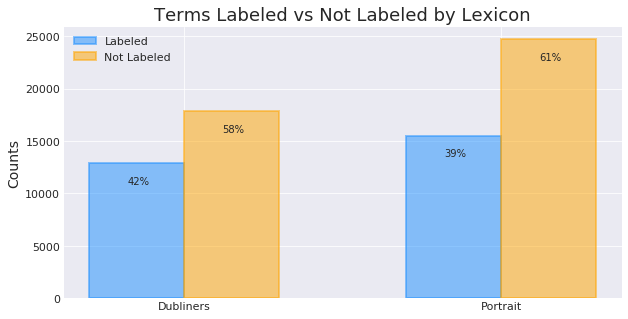

In [12]:
df_term_lex_sum = (df_proc_terms
                   .groupby('title')['anger']
                   .apply(lambda g: g.isnull().value_counts())
                   .to_frame('count'))
df_term_lex_sum.index.set_names(['title','is_labeled'], inplace=True)
df_term_lex_sum['percent'] = (df_proc_terms.groupby('title')['anger']
                              .apply(
                                  lambda g: g.isnull()
                                  .value_counts(normalize=True)))

bar_width = 0.3
alpha_lex = 0.5
line_width_lex = 2

bars_null = df_term_lex_sum.xs(True, level=1)['count'].tolist()
bars_not_null = df_term_lex_sum.xs(False, level=1)['count'].tolist()
bars_all = bars_null + bars_not_null

x_pos_null = list(range(len(bars_null)))
x_pos_not_null = [x + bar_width for x in x_pos_null]
x_pos_all = x_pos_null + x_pos_not_null

level_1_names = (df_term_lex_sum
                 .index
                 .get_level_values(0)
                 .str.title()
                 .unique()
                 .tolist())

# Maintain the same order as the bars and x positions.
percentages = (df_term_lex_sum
               .sort_values('is_labeled', ascending=False)['percent']
               .tolist())
percentages = ['{:.0%}'.format(p) for p in percentages]

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x_pos_null, bars_null, bar_width, alpha=alpha_lex,
       facecolor='C0', edgecolor='C0', linewidth=line_width_lex)

ax.bar(x_pos_not_null, bars_not_null, bar_width, alpha=alpha_lex,
       facecolor='C1', edgecolor='C1', linewidth=line_width_lex)

ax.set_xticks([x + .5 * bar_width for x in x_pos_null])
ax.set_xticklabels(level_1_names)
ax.set_ylabel('Counts')
ax.set_title('Terms Labeled vs Not Labeled by Lexicon')
ax.legend(['Labeled', 'Not Labeled'], loc='upper left')
for i in range(len(x_pos_all)):
    plt.text(x=x_pos_all[i]-0.03, y=bars_all[i]-2000, s=percentages[i])

plt.show(); 

It's possible that another lexicon, like the [Bing Liu lexicon](http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010) or the [AFINN lexicon](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html) might be able to classify more terms than the NRC Emotion Lexicon. Using another lexicon is out of scope of this analysis, but next steps could include implementing all three of the lexicons in a comparison to find the one that classifies the most terms and/or is most useful in detecting plot structure.   

# Export Data

Export `df_proc_terms`. Preserve the index, as this is a multi index data frame.

In [13]:
csv_file = os.path.join(data_processed, 'df-proc-terms.csv')
df_proc_terms.to_csv(csv_file, sep=',', encoding='utf-8')
print('df_proc_terms: {}'.format(df_proc_terms.shape))

df_proc_terms: (70873, 11)


Export `df_raw_chptrs`.

In [14]:
csv_file = os.path.join(data_processed, 'df-raw-chptrs.csv')
df_raw_chptrs.to_csv(csv_file, sep=',', index=False, encoding='utf-8')
print('df_raw_chptrs: {}'.format(df_raw_chptrs.shape))

df_raw_chptrs: (20, 3)


Export `df_tf`. Preserve the index, as this is a multi index data frame.

In [15]:
csv_file = os.path.join(data_processed, 'df-tf.csv')
df_tf.to_csv(csv_file, sep=',', encoding='utf-8')
print('df_tf: {}'.format(df_tf.shape))

df_tf: (26708, 12)


Export `dubliners_raw_chptr` and `portrait_raw_chptr`.

In [16]:
path_txt_chptr = os.path.join(data_processed, 'dubliners-raw-chptr')
with open(path_txt_chptr, 'wb') as fp:
    pickle.dump(dubliners_raw_chptr, fp)

path_txt_chptr = os.path.join(data_processed, 'portrait-raw-chptr')
with open(path_txt_chptr, 'wb') as fp:
    pickle.dump(portrait_raw_chptr, fp)